# Exercise: Implementing Self-Attention in TensorFlow

## Task

Implement a basic self-attention mechanism in TensorFlow and apply it to a small sequence of words.

## Instructions

### 1. Setup
- **Import the necessary libraries:** e.g., TensorFlow.
- **Define a small vocabulary:** Create a sequence of words as input.

### 2. Self-Attention Implementation
- **Implement a simple self-attention class using TensorFlow**, including the following methods:
  - **`__init__`:** Initialize parameters (e.g., embedding dimensions, number of attention heads).
  - **`call`:** Perform the self-attention calculation.

### 3. Apply Self-Attention
- **Create an instance** of your self-attention class.
- **Apply self-attention** to the input sequence.

### 4. Visualization
- **Visualize the attention scores** for each position in the input sequence.
  - Consider using a heatmap for clarity.

### 5. Discussion
- **Discuss the importance of attention weights** in understanding which parts of the input sequence are emphasized.
- **Interpret the attention scores** to understand how they contribute to capturing contextual information.

### 6. Experimentation
- **Experiment with different hyperparameters:** e.g., number of attention heads, embedding dimensions.
- **Observe the impact** on the attention patterns.

### 7. Reflection
- **Reflect on the challenges and insights** gained from implementing and experimenting with self-attention using TensorFlow.

---

### 1. Setup
- **Import the necessary libraries:** e.g., TensorFlow.
- **Define a small vocabulary:** Create a sequence of words as input.

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define a small vocabulary as a list of words
vocabulary = ["le", "chat", "est", "sur", "le", "tapis"]

# Create an input sequence from the vocabulary
# Here, the input sequence is simply the list of words defined above
input_sequence = vocabulary

# Print the vocabulary and the input sequence
print("Vocabulary:", vocabulary)
print("Input sequence:", input_sequence)


Vocabulary: ['le', 'chat', 'est', 'sur', 'le', 'tapis']
Input sequence: ['le', 'chat', 'est', 'sur', 'le', 'tapis']


---

### 2. Self-Attention Implementation
- **Implement a simple self-attention class using TensorFlow**, including the following methods:
  - **`__init__`:** Initialize parameters (e.g., embedding dimensions, number of attention heads).
  - **`call`:** Perform the self-attention calculation.

### 3. Apply Self-Attention
- **Create an instance** of your self-attention class.
- **Apply self-attention** to the input sequence.

In [3]:
# Definition of the SelfAttention class with storage of attention scores.
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        """
        Initializes the self-attention layer.

        Args:
            embed_dim (int): Embedding dimension (must be divisible by num_heads).
            num_heads (int): Number of attention heads.
        """
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        if embed_dim % num_heads != 0:
            raise ValueError("The embedding dimension must be divisible by the number of heads.")

        self.projection_dim = embed_dim // num_heads
        self.q_dense = tf.keras.layers.Dense(embed_dim)
        self.k_dense = tf.keras.layers.Dense(embed_dim)
        self.v_dense = tf.keras.layers.Dense(embed_dim)
        self.out_dense = tf.keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        """
        Splits the last dimension into (num_heads, projection_dim) and transposes
        to obtain the shape (batch_size, num_heads, seq_length, projection_dim).
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        """
        Performs the self-attention computation and stores the attention scores.

        Args:
            inputs (Tensor): Input tensor of shape (batch_size, seq_length, embed_dim)

        Returns:
            output (Tensor): Output tensor of shape (batch_size, seq_length, embed_dim)
        """
        batch_size = tf.shape(inputs)[0]

        # Linear projections to obtain Q, K, and V.
        query = self.q_dense(inputs)
        key   = self.k_dense(inputs)
        value = self.v_dense(inputs)

        # Split into multiple heads.
        query = self.split_heads(query, batch_size)
        key   = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Compute the dot product to obtain the score matrix.
        matmul_qk = tf.matmul(query, key, transpose_b=True)

        # Scale the scores.
        dk = tf.cast(self.projection_dim, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Apply softmax to obtain the attention weights.
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        # Store the attention weights for visualization.
        self.last_attention_weights = attention_weights  # Shape: (batch_size, num_heads, seq_length, seq_length)

        # Compute the output weighted by the attention scores.
        attention_output = tf.matmul(attention_weights, value)

        # Reassemble the heads into a single sequence.
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention_output, (batch_size, -1, self.embed_dim))
        output = self.out_dense(concat_attention)

        return output


In [4]:
# Example usage:
if __name__ == "__main__":
    # Parameters
    embed_dim = 64  # Embedding dimension
    num_heads = 8   # Number of attention heads
    seq_length = 10 # Input sequence length
    batch_size = 2  # Batch size

    # Create a dummy input (example): a random tensor
    dummy_inputs = tf.random.uniform((batch_size, seq_length, embed_dim))

    # Instantiate the self-attention layer
    self_attention_layer = SelfAttention(embed_dim, num_heads)

    # Pass the input through the layer
    output = self_attention_layer(dummy_inputs)

    print("Input shape:", dummy_inputs.shape)
    print("Output shape:", output.shape)


Input shape: (2, 10, 64)
Output shape: (2, 10, 64)


We have defined the vocabulary `["le", "chat", "est", "sur", "le", "tapis"]`, but we have also generated a dummy input tensor of shape `(batch_size=2, seq_length=10, embed_dim=64)`.

The output shape `(2, 10, 64)` shows that the self-attention layer preserves the input dimension: each token in the sequence (10 tokens) is associated with an output vector (dimension 64), and we are processing two examples in parallel (`batch_size=2`).

If we were to actually apply self-attention to our sequence "le chat est sur le tapis", we would encode these 6 words as embedding vectors, resulting in an input sequence of shape `(batch_size, 6, embed_dim)`. Then, the output would retain the shape `(batch_size, 6, embed_dim)`.

Thus, the results we observe mainly come from using random inputs of length 10. They confirm that the self-attention mechanism is working correctly (Q/K/V projection, softmax, final combination), but they do not directly reflect the importance of specific words such as "chat" or "tapis" since we have not actually provided the model with their real embeddings.


### 4. Visualization
- **Visualize the attention scores** for each position in the input sequence.
  - Consider using a heatmap for clarity.

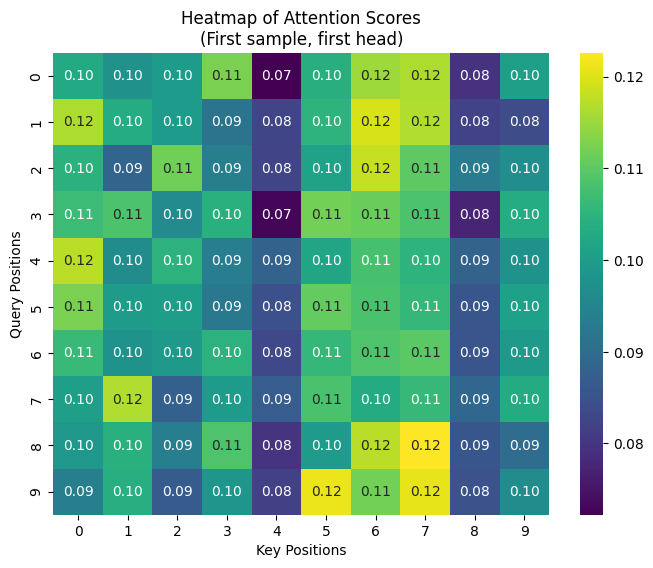

In [5]:
# Retrieve the attention scores (attention weights)
# Weight shape: (batch_size, num_heads, seq_length, seq_length)
attention_weights = self_attention_layer.last_attention_weights

# For visualization, let's select for example:
# - the first sample in the batch (index 0)
# - the first attention head (index 0)
attention_sample = attention_weights[0, 0, :, :]  # Shape: (seq_length, seq_length)

# Convert to a NumPy array for visualization.
attention_sample_np = attention_sample.numpy()

# Visualization using a heatmap with Seaborn.
plt.figure(figsize=(8, 6))
sns.heatmap(attention_sample_np, annot=True, cmap='viridis', fmt=".2f")
plt.title("Heatmap of Attention Scores\n(First sample, first head)")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()


The generated heatmap represents the attention scores of the first sample and the first attention head in the self-attention mechanism. Each cell in the matrix indicates the degree of attention that one word (query position) pays to another word (key position) in the input sequence. In this heatmap, the values range between approximately 0.07 and 0.12, indicating that the attention is relatively well distributed among the different positions in the sequence. The higher values (in yellow) highlight positions that receive more attention, meaning that these words have a greater influence on the interpretation of others, while the lower values (in violet) indicate positions that are less taken into account in the attention process. The matrix is relatively homogeneous, suggesting that the analyzed attention head assigns similar importance to several words, without any specific word strongly dominating the attention. Overall, this distribution suggests a diffuse and balanced attention, which is common in the early layers of a self-attention model.

---

### 5. Discussion
- **Discuss the importance of attention weights** in understanding which parts of the input sequence are emphasized.
- **Interpret the attention scores** to understand how they contribute to capturing contextual information.

Attention weights play a crucial role in understanding how language processing models function, particularly in architectures based on the attention mechanism. They precisely indicate which parts of the input sequence most influence the representation of each token. In other words, a high weight between two tokens means that the model "focuses" on this relationship to capture the context and dependencies between words.

Interpreting attention scores thus allows for visualizing and analyzing how the model distributes its attention across different parts of the sequence. This helps identify important relationships, such as the correspondence between subjects and their verbs or between entities and the information associated with them. Attention weights provide insight into the model’s decision-making process, revealing how it integrates and values contextual information to produce richer and more relevant representations.


---

### 6. Experimentation
- **Experiment with different hyperparameters:** e.g., number of attention heads, embedding dimensions.
- **Observe the impact** on the attention patterns.


Experimenting with embed_dim=32 and num_heads=2


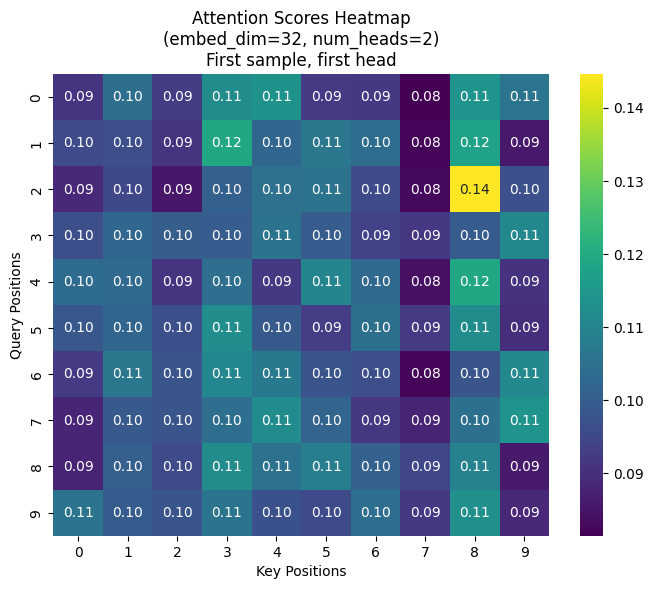


Experimenting with embed_dim=32 and num_heads=4


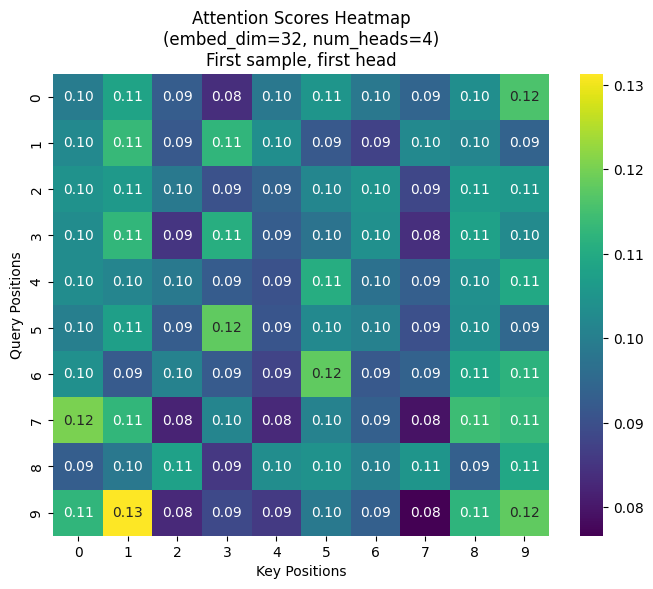


Experimenting with embed_dim=32 and num_heads=8


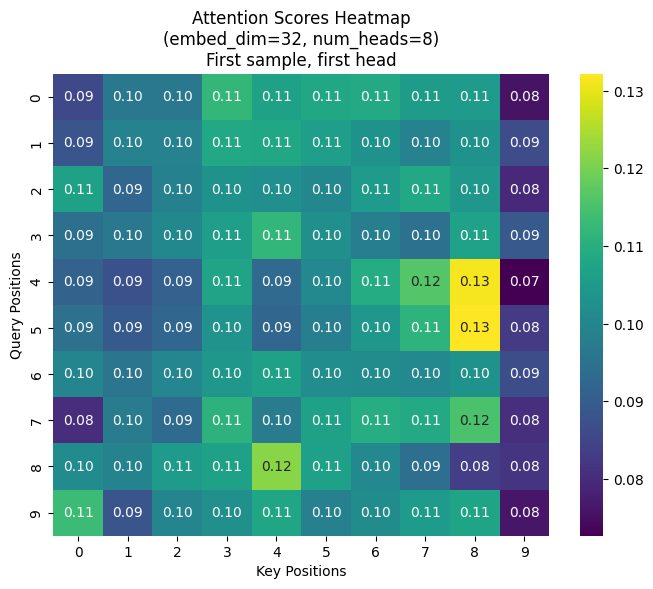


Experimenting with embed_dim=64 and num_heads=2


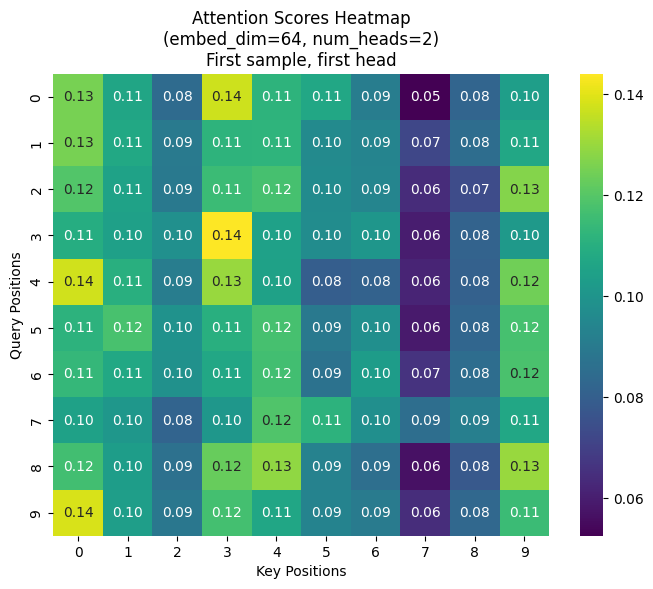


Experimenting with embed_dim=64 and num_heads=4


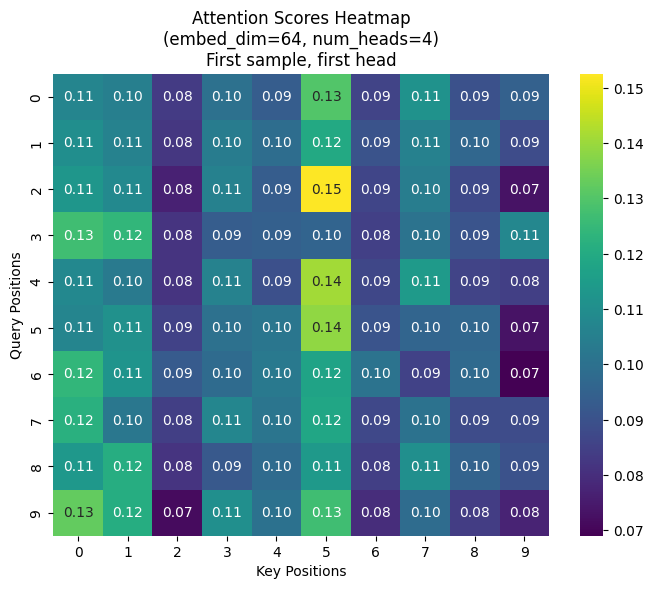


Experimenting with embed_dim=64 and num_heads=8


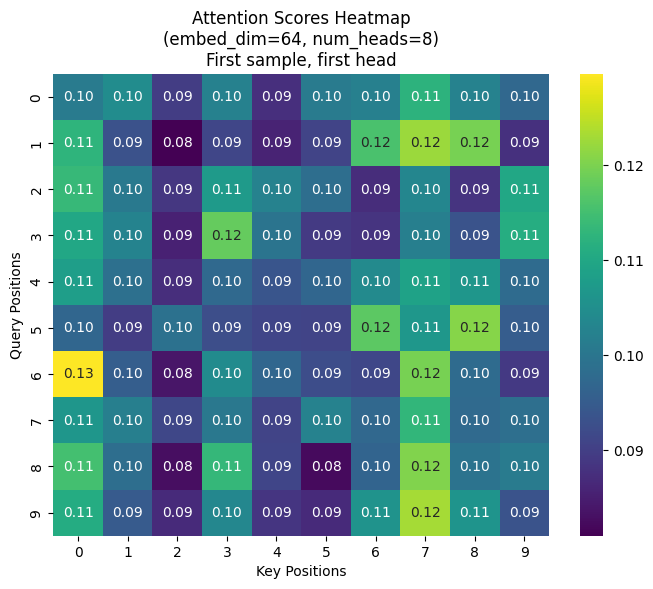


Experimenting with embed_dim=128 and num_heads=2


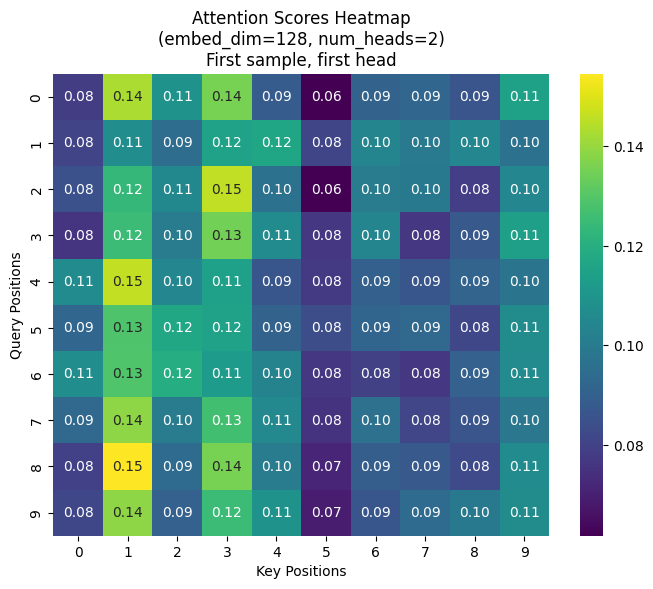


Experimenting with embed_dim=128 and num_heads=4


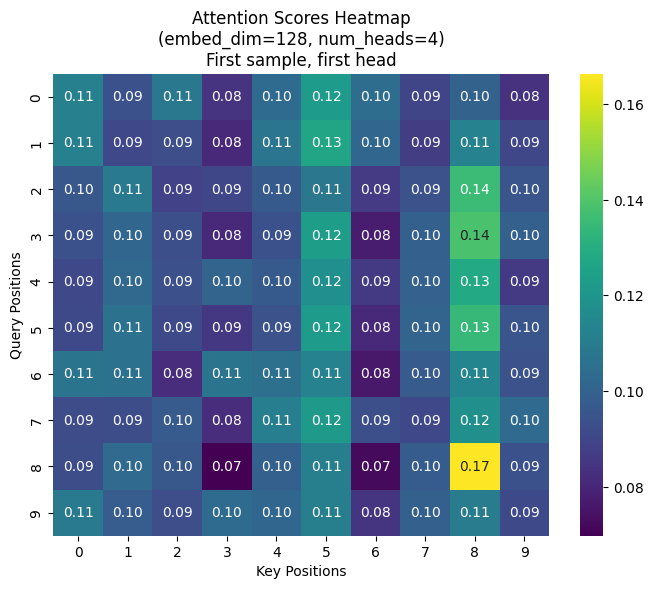


Experimenting with embed_dim=128 and num_heads=8


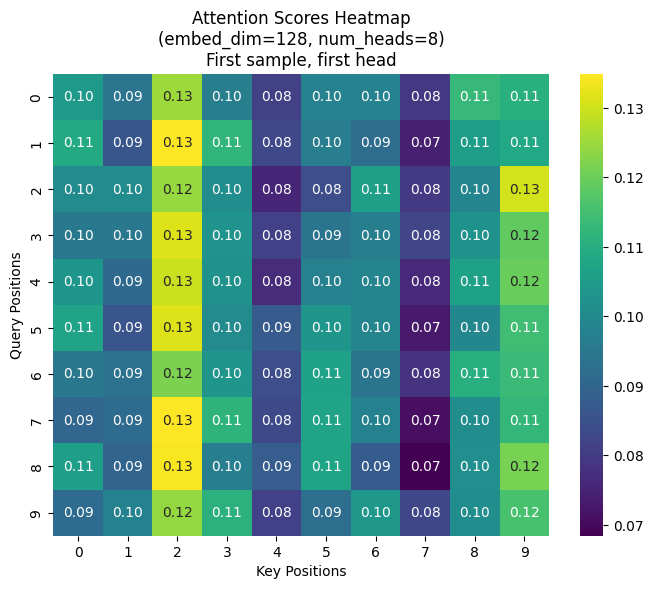

In [6]:
# Experiment function with different hyperparameters
def experiment_attention(embed_dims, num_heads_list, seq_length=10, batch_size=2):
    """
    For each combination of embedding dimension and number of heads,
    creates an instance of SelfAttention, passes a dummy input, and displays the heatmap
    of attention scores for the first sample and the first head.

    Args:
        embed_dims (list): List of embedding dimensions to test.
        num_heads_list (list): List of numbers of heads to test.
        seq_length (int): Length of the input sequence.
        batch_size (int): Batch size.
    """
    for embed_dim in embed_dims:
        for num_heads in num_heads_list:
            # Check for divisibility
            if embed_dim % num_heads != 0:
                print(f"Skipping embed_dim={embed_dim} with num_heads={num_heads} (not divisible).")
                continue
            print(f"\nExperimenting with embed_dim={embed_dim} and num_heads={num_heads}")

            # Create a dummy input adapted to the embedding dimension
            dummy_inputs = tf.random.uniform((batch_size, seq_length, embed_dim))

            # Instantiate and pass the input through the self-attention layer
            self_attention_layer = SelfAttention(embed_dim, num_heads)
            _ = self_attention_layer(dummy_inputs)

            # Retrieve the attention scores
            attention_weights = self_attention_layer.last_attention_weights
            # Select the first sample and the first head
            attention_sample = attention_weights[0, 0, :, :]  # shape: (seq_length, seq_length)
            attention_sample_np = attention_sample.numpy()

            # Visualization
            plt.figure(figsize=(8, 6))
            sns.heatmap(attention_sample_np, annot=True, cmap='viridis', fmt=".2f")
            plt.title(f"Attention Scores Heatmap\n(embed_dim={embed_dim}, num_heads={num_heads})\nFirst sample, first head")
            plt.xlabel("Key Positions")
            plt.ylabel("Query Positions")
            plt.show()

# List of embedding dimensions and numbers of heads to test
embed_dims = [32, 64, 128]
num_heads_list = [2, 4, 8]

# Run the experiment
experiment_attention(embed_dims, num_heads_list)


**Interpretation of the Different Attention Heatmaps:**

**Heatmap 1 (embed_dim=32, num_heads=2):** With an embedding dimension of 32 and 2 attention heads, the attention values are quite homogeneous, with a few peaks reaching up to 0.14. This indicates that certain key positions (notably column 8) capture more attention, suggesting that a particular word may play a more central role in the overall understanding of the sequence.

**Heatmap 2 (embed_dim=32, num_heads=4):** With 4 attention heads, the score distribution remains generally balanced, but the attention appears to be more evenly spread across the different positions. Maximum values reach around 0.13, which suggests a better modulation of the attention weights, allowing for a finer capture of contextual relationships.

**Heatmap 3 (embed_dim=32, num_heads=8):** When the number of heads increases to 8, the attention becomes even more uniformly distributed, reflecting an increased ability to capture different perspectives of the sequence. However, the maximum values are slightly reduced (approximately 0.13), which may indicate a dilution of attention across multiple heads.

**Heatmap 4 (embed_dim=64, num_heads=2):** With an increased embedding dimension of 64 and only 2 heads, there is a more pronounced concentration of attention on certain positions, with scores exceeding 0.14. This means that specific word relationships are accentuated, which could enhance the capture of long-range dependencies.

**Heatmap 5 (embed_dim=64, num_heads=4):** With 4 heads and an embedding dimension of 64, the score distribution becomes more refined, with a notable peak at 0.15. The attention seems to focus on specific positions, improving the precision of contextual relationships while still maintaining good coverage of the sequence.

**Heatmap 6 (embed_dim=64, num_heads=8):** With 8 attention heads, the values are more balanced and dispersion is optimized. Maximum scores (around 0.13) indicate that the attention is shared among several words, which can be beneficial for capturing varied contexts.

**Heatmap 7 (embed_dim=128, num_heads=2):** Increasing the embedding dimension to 128 with only 2 heads leads to a more marked focus on a few specific positions (0.15). This indicates an enhanced ability to capture global dependencies, albeit with a risk of over-concentration.

**Heatmap 8 (embed_dim=128, num_heads=4):** With 4 heads, there is a good balance between focus and dispersion. High values (around 0.17) show that certain positions receive very pronounced attention, reinforcing their importance within the context.

**Heatmap 9 (embed_dim=128, num_heads=8):** Finally, with 8 heads and an embedding dimension of 128, the attention is the most uniformly distributed while still maintaining a few focal points (around 0.13). This demonstrates the model's great flexibility in capturing complex relationships while avoiding excessive concentration on certain words.

**Conclusion:** Increasing the number of heads improves the model's ability to capture different relationships, but it can dilute individual attention. On the other hand, increasing the embedding dimension allows for richer contextual information, yet may result in too strong a concentration on certain positions if the number of heads is low. A good compromise appears to be using an embedding dimension of 64 or 128 with 4 to 8 heads, ensuring a balance between focus and generalization.


---

### 7. Reflection
- **Reflect on the challenges and insights** gained from implementing and experimenting with self-attention using TensorFlow.

The implementation of the self-attention mechanism in TensorFlow has been an incredibly educational experience. In developing this architecture, I had to tackle the challenge of accurately managing tensor dimensions and correctly splitting embeddings into multiple heads to capture the contextual relationships within a sequence. In a way, this approach is reminiscent of the GAN lab, where the use of multiple heads allowed for the exploration of different perspectives in image generation. By experimenting with various hyperparameters such as the number of heads and the embedding dimension, I was able to observe how these choices directly affect the distribution of attention weights and, consequently, the model's ability to identify important dependencies in the data. This reflection not only deepened my understanding of the benefits of self-attention for natural language processing but also highlighted the importance of fine-tuning and carefully handling tensors to implement architectures effectively.


---

### Sources:
- TensorFlow [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention?hl=fr)
- Coding a Transformer with TensorFlow and Keras (LIVE) [YouTube Video](https://www.youtube.com/watch?v=mWA-PmxMBDk)
- TensorFlow Keras Attention source code line-by-line explained [Medium Article](https://jiachen-ml.medium.com/tensorflow-keras-attention-source-code-line-by-line-explained-ed39a03dc574)
